In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
from matplotlib.ticker import MultipleLocator,ScalarFormatter
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
import random
import json

plt.rcParams["pdf.fonttype"]=42

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

small_font = 8
plt.rcParams["font.size"] = 10

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')


In [2]:
volcanodata = pd.read_excel("S3_MI_compilation_XH2O_revised.xlsx", sheet_name="TableS-9 XH2O_calc_filtered", skiprows=[0])
vdatafilt = volcanodata.copy()
vdatafilt.loc[:, 'Raman/Homog'] = vdatafilt['Raman/Homog'].fillna('')

## Plot FIGURE 3

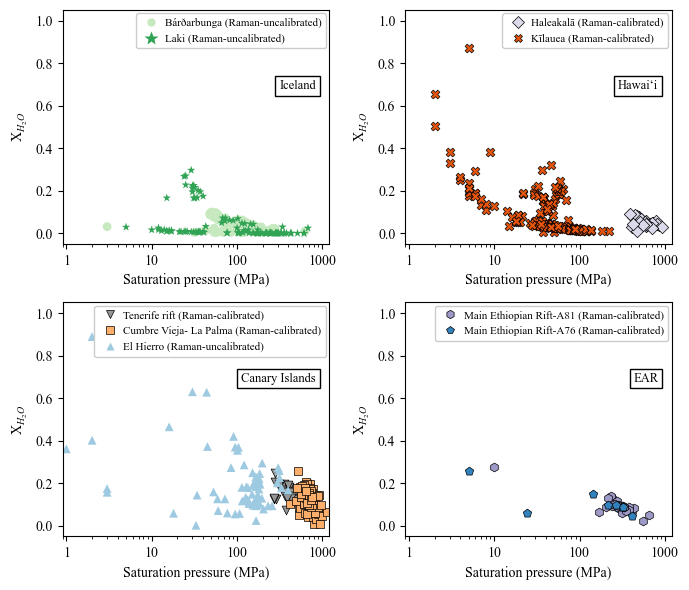

In [3]:


markeredge=0.5
# Define flags to control which subsets to plot
plot_glassonly = False  # Set to True to plot glassonly
plot_ramancal = True     # Set to True to plot ramancal
plot_ramanuncal = True   # Set to True to plot ramanuncal

x_col = 'SaturationP_bars_VESIcal'
y_col = 'XH2O_fl_VESIcal'

# Define the locations you want to plot
locations = ['Iceland', 'Hawaiʻi', 'Canary Islands', 'EAR']

# Define markers
markers = ['o', 's', '^', 'D', 'X', '*', 'p', 'h', 'v', '<', '>', 'd']

# Normalize volcano names to remove '-Raman' suffix
def normalize_volcano_name(name):
    if '-Raman' in name:
        return name.split('-Raman')[0]
    if ' - Raman' in name:
        return name.split(' - Raman')[0]
    return name

# Define a colormap with a high number of distinct colors
def get_distinct_cmap(num_colors):
    return plt.get_cmap('tab20c')

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(7, 6))

# Collect all unique volcanoes across all locations
all_volcanoes = set()
for location in locations:
    data_location = vdatafilt[vdatafilt['Location'] == location].copy()
    data_location['NormalizedVolcano'] = data_location['Volcano'].apply(normalize_volcano_name)
    all_volcanoes.update(data_location['NormalizedVolcano'].unique())

# Prepare maps to store colors and markers for displayed data
volcano_color_map = {}
volcano_marker_map = {}

# Determine the subset of volcanoes to plot
displayed_volcanoes = set()
for location in locations:
    data_location = vdatafilt[vdatafilt['Location'] == location].copy()
    data_location['NormalizedVolcano'] = data_location['Volcano'].apply(normalize_volcano_name)

    if plot_glassonly:
        displayed_volcanoes.update(data_location[~data_location['Raman/Homog'].str.contains('Raman')]['NormalizedVolcano'].unique())
    if plot_ramancal:
        displayed_volcanoes.update(data_location[data_location['Raman/Homog'].str.contains('Raman-cal')]['NormalizedVolcano'].unique())
    if plot_ramanuncal:
        displayed_volcanoes.update(data_location[data_location['Raman/Homog'].str.contains('Raman-uncal')]['NormalizedVolcano'].unique())

# Generate colormap and markers for displayed volcanoes
num_volcanoes = len(displayed_volcanoes)
cmap = get_distinct_cmap(num_volcanoes)
colors = [to_hex(cmap(i / num_volcanoes)) for i in range(num_volcanoes)]

# Shuffle colors to randomize their order and ensure no repetition
random.shuffle(colors)

# Load saved colors
with open('saved_colors.json', 'r') as f:
    colors = json.load(f)

# Map volcano names to random colors
volcano_color_map = {volcano: colors[i % len(colors)] for i, volcano in enumerate(sorted(displayed_volcanoes))}
volcano_marker_map = {volcano: markers[i % len(markers)] for i, volcano in enumerate(sorted(displayed_volcanoes))}

# Adjust marker sizes for legend
default_marker_size = 6  # General marker size
star_marker_size = 10     # Size for star markers

# Plot for each location
for i, location in enumerate(locations):
    row_index = i // 2
    col_index = i % 2

    # Filter the data for the current location
    data_location = vdatafilt[vdatafilt['Location'] == location].copy()
    data_location['NormalizedVolcano'] = data_location['Volcano'].apply(normalize_volcano_name)

    glassonly = data_location[~data_location['Raman/Homog'].str.contains('Raman')]
    ramancal = data_location[data_location['Raman/Homog'].str.contains('Raman-cal')]
    ramanuncal = data_location[data_location['Raman/Homog'].str.contains('Raman-uncal')]

    # Collect handles and labels for the subsets
    plot_handles = []
    plot_labels = []

    # Plot Glass-only data
    if plot_glassonly:
        for volcano in glassonly['NormalizedVolcano'].unique():
            if volcano in displayed_volcanoes:
                volcano_data = glassonly[glassonly['NormalizedVolcano'] == volcano]
                axs[row_index, col_index].scatter(volcano_data[x_col] / 10, volcano_data[y_col],
                                                  c='none',  # Color by Volcano
                                                  marker=volcano_marker_map[volcano],  # Symbol by Volcano
                                                  s=80,
                                                  edgecolor=volcano_color_map[volcano])  # No border for Glass-only data
                if volcano not in plot_labels:
                    marker_size = star_marker_size if volcano_marker_map[volcano] == '*' else default_marker_size
                    plot_handles.append(Line2D([0], [0], marker=volcano_marker_map[volcano],
                                                 color='none', markerfacecolor='none',
                                                 markeredgecolor=volcano_color_map[volcano], markersize=marker_size))
                    plot_labels.append(f'{volcano} (glass-only)')

    # Plot Raman-calibrated data
    if plot_ramancal:
        for volcano in ramancal['NormalizedVolcano'].unique():
            if volcano in displayed_volcanoes:
                volcano_data = ramancal[ramancal['NormalizedVolcano'] == volcano]
                axs[row_index, col_index].scatter(volcano_data[x_col] / 10, volcano_data[y_col],
                                                  c=volcano_color_map[volcano],  # Color by Volcano
                                                  marker=volcano_marker_map[volcano],  # Symbol by Volcano
                                                  s=40,
                                                  edgecolor='k',linewidth=markeredge)  # Black border for Raman-calibrated data
                if volcano not in plot_labels:
                    marker_size = star_marker_size if volcano_marker_map[volcano] == '*' else default_marker_size
                    plot_handles.append(Line2D([0], [0], marker=volcano_marker_map[volcano],
                                                 color='none', markerfacecolor=volcano_color_map[volcano],
                                                 markeredgecolor='k', markersize=marker_size,markeredgewidth=markeredge))
                    plot_labels.append(f'{volcano} (Raman-calibrated)')

    # Plot Raman-uncalibrated data
    if plot_ramanuncal:
        for volcano in ramanuncal['NormalizedVolcano'].unique():
            if volcano in displayed_volcanoes:
                volcano_data = ramanuncal[ramanuncal['NormalizedVolcano'] == volcano]
                axs[row_index, col_index].scatter(volcano_data[x_col] / 10, volcano_data[y_col],
                                                  c=volcano_color_map[volcano],  # Color by Volcano
                                                  marker=volcano_marker_map[volcano],  # Symbol by Volcano
                                                  s=40,
                                                  edgecolor='none')  # No border for Raman-uncalibrated data
                if volcano not in plot_labels:
                    marker_size = star_marker_size if volcano_marker_map[volcano] == '*' else default_marker_size
                    plot_handles.append(Line2D([0], [0], marker=volcano_marker_map[volcano],
                                                 color='none', markerfacecolor=volcano_color_map[volcano],
                                                 markeredgecolor='none', markersize=marker_size))
                    plot_labels.append(f'{volcano} (Raman-uncalibrated)')
    # Combine volcano legend handles and labels
    legend_params = {
        'fontsize': 8,
        'ncols': 1,
        'loc': 'upper right',
        'labelspacing': 0.5,
        'columnspacing': 0.2,
        'borderpad': 0.4,
        'handletextpad': 0.2,
        'framealpha': 1,
        'borderaxespad': 0.3
    }
    axs[row_index, col_index].legend(handles=plot_handles, labels=plot_labels, **legend_params)

    # Set limits and labels
    axs[row_index, col_index].set_xscale("log")
    axs[row_index, col_index].set_ylim([-0.05, 1.05])
    axs[row_index, col_index].set_xlabel('Saturation pressure (MPa)')
    axs[row_index, col_index].set_ylabel('X$_{H_2O}$')
    axs[row_index, col_index].set_xlim([0.9, 1200])
    axs[row_index, col_index].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    # Add annotation
    axs[row_index, col_index].annotate(location, xy=(0.95, 0.70), xycoords='axes fraction', fontsize=9,
                                       ha='right', bbox=bbox, va='top')

# Adjust layout
plt.tight_layout()
plt.show()

# Save the figure
directory = os.path.join(os.getcwd(), 'Notebook_output')
if not os.path.exists(directory):
    os.makedirs(directory)

# bbox = dict(boxstyle='square', facecolor='white', edgecolor='black')
# axs[0,0].text(10, 0.50, 'a', transform=axs[0,0].transAxes, fontsize=9, va='bottom', ha='right',bbox=bbox)

fig.savefig(os.path.join(directory, 'Fig3_PXH2O.pdf'))
fig.savefig(os.path.join(directory, 'Fig3_PXH2O.eps'))
fig.savefig(os.path.join(directory, 'Fig3_PXH2O.png'),dpi=300)


## FIG S8 Loop plots supplement

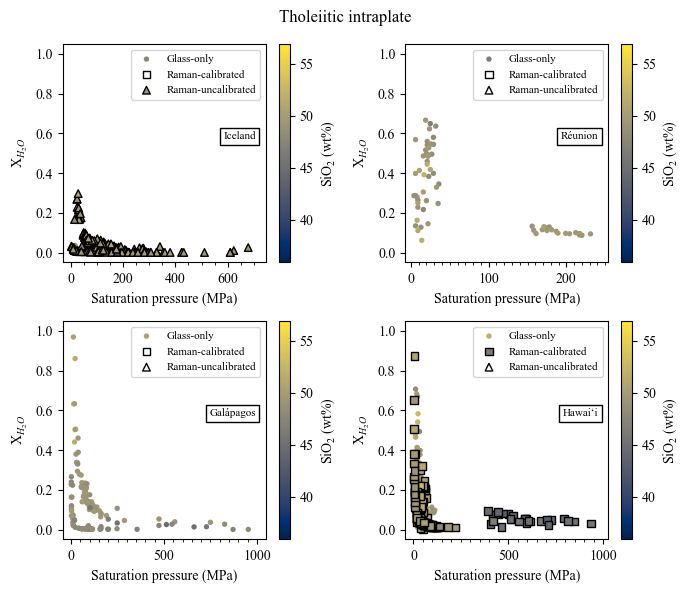

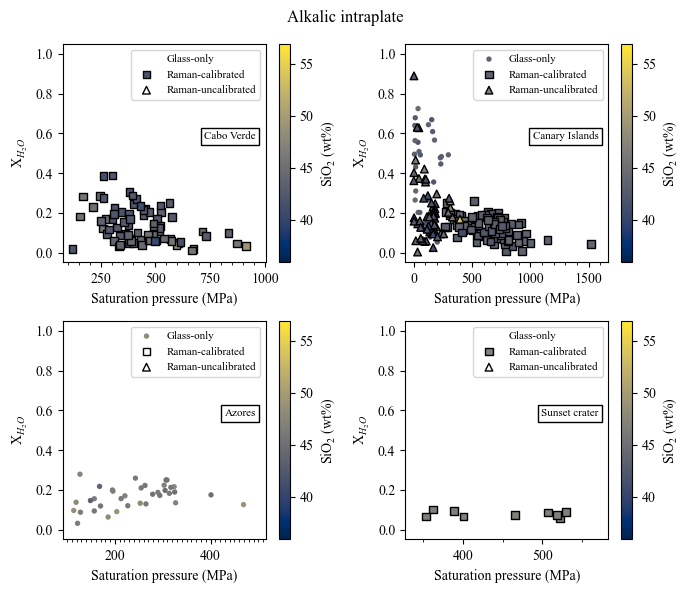

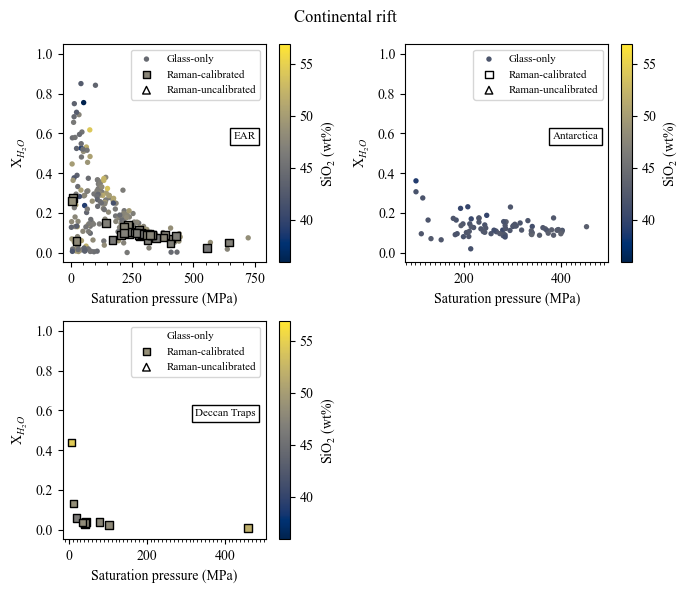

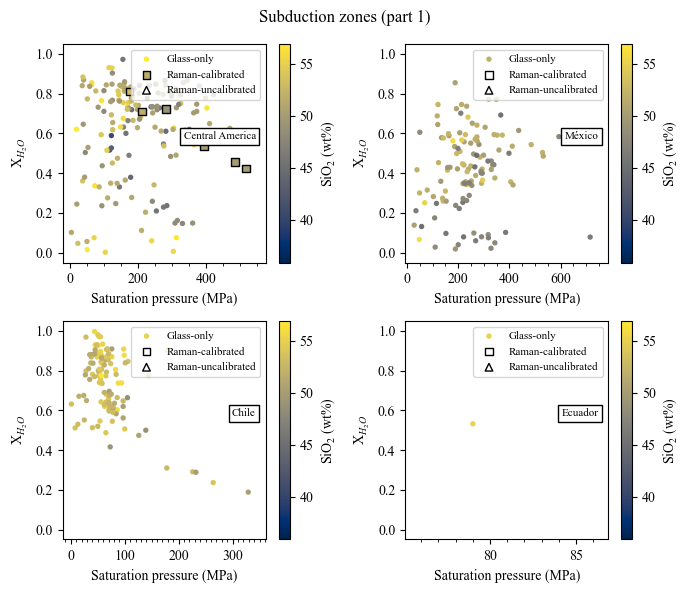

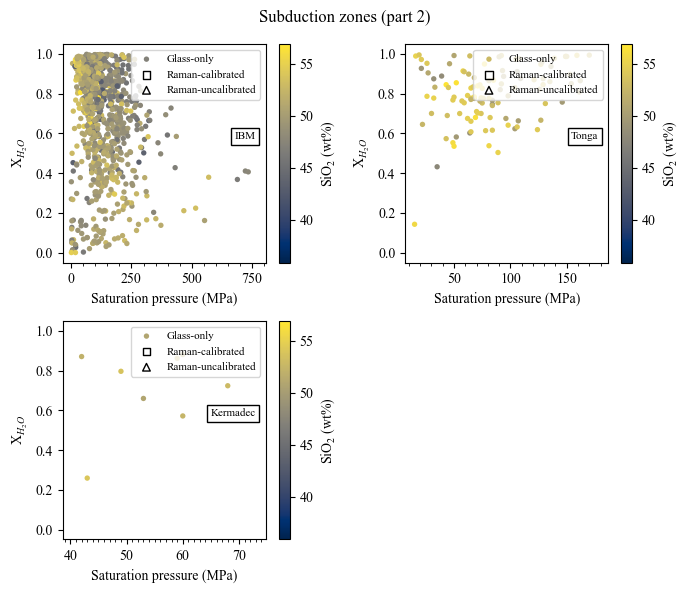

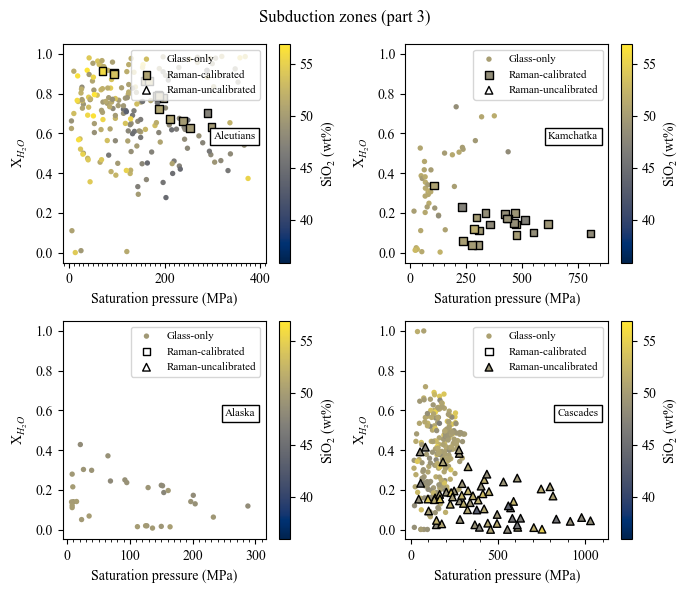

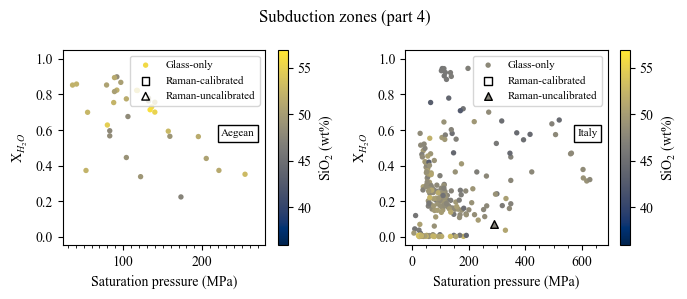

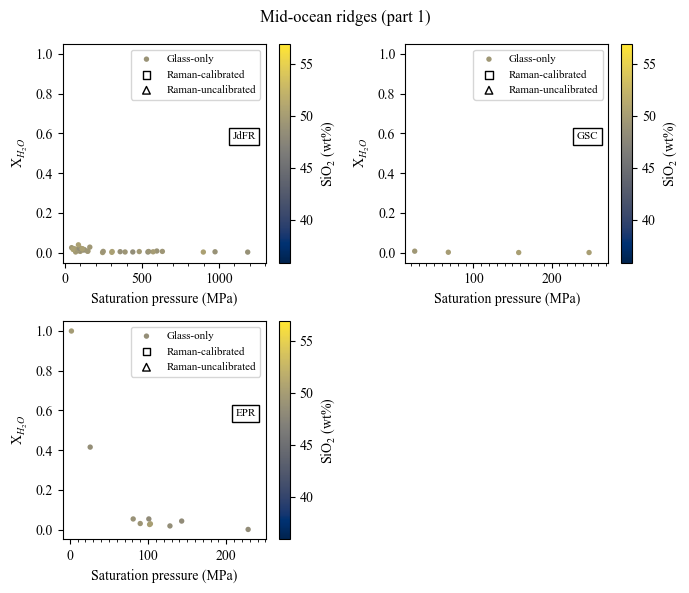

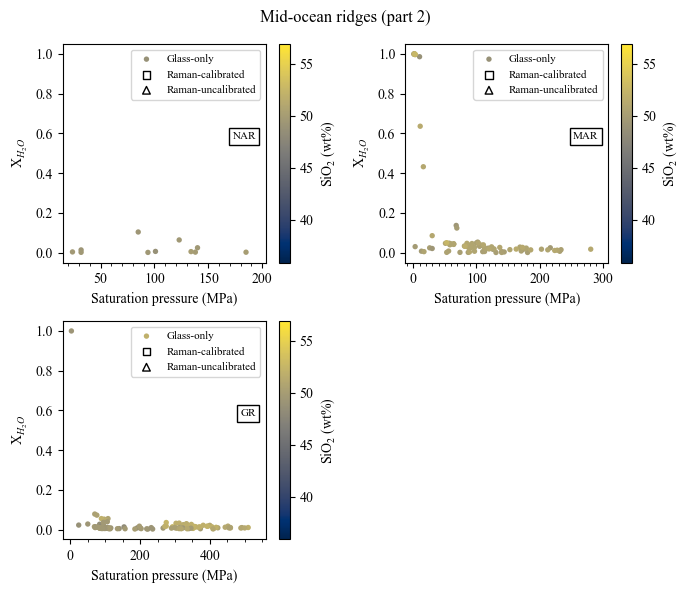

In [4]:
bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

siO2_min_all = vdatafilt['SiO2'].min()
siO2_max_all = vdatafilt['SiO2'].max()

# Convert saturation pressure from bars to MPa
satP_min_all = vdatafilt['SaturationP_bars_VESIcal'].min() / 10
satP_max_all = vdatafilt['SaturationP_bars_VESIcal'].max() / 10

siO2_colormap = plt.get_cmap('cividis')

x_col = 'SaturationP_bars_VESIcal'
y_col = 'XH2O_fl_VESIcal'

# Lists of 'Location type'
locations_lists = [
    ['Iceland', 'Réunion', 'Galápagos', 'Hawaiʻi'],
    ['Cabo Verde', 'Canary Islands', 'Azores', 'Sunset crater'],
    ['EAR', 'Antarctica', 'Deccan Traps'],
    ['Central America', 'México', 'Chile', 'Ecuador'],
    ['IBM', 'Tonga', 'Kermadec'],
    ['Aleutians', 'Kamchatka', 'Alaska', 'Cascades'],
    ['Aegean', 'Italy'],
    ['JdFR', 'GSC', 'EPR'],
    ['NAR', 'MAR', 'GR']
]
loctype_lists = [
    'Tholeiitic intraplate',
    'Alkalic intraplate',
    'Continental rift',
    'Subduction zones (part 1)',
    'Subduction zones (part 2)',
    'Subduction zones (part 3)',
    'Subduction zones (part 4)',
    'Mid-ocean ridges (part 1)',
    'Mid-ocean ridges (part 2)'
]

# Determine the number of rows needed for subplot arrangement for each location list
num_cols = 2
num_rows = [((len(locations) + num_cols - 1) // num_cols) for locations in locations_lists]

# Create subplots for each location list
for locations, num_row, loc_type in zip(locations_lists, num_rows, loctype_lists):
    fig, axs = plt.subplots(num_row, num_cols, figsize=(3.5*num_cols, 3*num_row))  # 5 columns

    # Flatten the axs array if there's only one row
    if num_row == 1:
        axs = axs.reshape(1, -1)

    for i, location in enumerate(locations):
        row_index = i // num_cols
        col_index = i % num_cols

        glassonly = vdatafilt[(vdatafilt['Location'] == location) & ~(vdatafilt['Raman/Homog'].str.contains('Raman|Homog'))]
        ramancal = vdatafilt[(vdatafilt['Location'] == location) & (vdatafilt['Raman/Homog'].str.contains('Raman-cal'))]
        ramanuncal = vdatafilt[(vdatafilt['Location'] == location) & (vdatafilt['Raman/Homog'].str.contains('Raman-uncal'))]

        scatter_glassonly = axs[row_index, col_index].scatter(glassonly[x_col] / 10, glassonly[y_col],
                                                              c=glassonly['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                              edgecolor='none', s=15, label='Glass-only', marker='o')

        scatter_ramancal = axs[row_index, col_index].scatter(ramancal[x_col] / 10, ramancal[y_col],
                                                              c=ramancal['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                              edgecolor='k', s=30, label='Raman-calibrated', marker='s')

        scatter_ramanuncal = axs[row_index, col_index].scatter(ramanuncal[x_col] / 10, ramanuncal[y_col],
                                                                c=ramanuncal['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                                edgecolor='k', s=30, label='Raman-uncalibrated', marker='^')

        max_x=max(vdatafilt[(vdatafilt['Location'] == location)][x_col])/10
        min_x=min(vdatafilt[(vdatafilt['Location'] == location)][x_col])/10
        # Add annotation
        axs[row_index, col_index].annotate(location, xy=(0.95, 0.60), xycoords='axes fraction', fontsize=small_font,
                                           ha='right', va='top', bbox=bbox,transform=axs[row_index,col_index].transAxes)

        axs[row_index, col_index].set_xlabel('Saturation pressure (MPa)')  # Update x-axis label
        axs[row_index, col_index].set_ylabel('X$_{H_2O}$')

        axs[row_index, col_index].legend(loc='upper right',fontsize=8)
        axs[row_index, col_index].set_ylim([-0.05, 1.05])
        axs[row_index, col_index].set_xlim([min_x-0.05*max_x, max_x+0.1*max_x])  # Update x-axis limit


        if max_x < 100:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(1))
        elif 100 <= max_x < 500:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(10))
        elif 500 <= max_x < 1000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(50))
        elif 1000 <= max_x < 5000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(100))
        elif max_x>=5000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(500))


        # Add color bar
        cbar_glassonly = fig.colorbar(scatter_glassonly, ax=axs[row_index, col_index])
        cbar_glassonly.set_label('SiO$_2$ (wt%)')
    
    fig.suptitle(loc_type)
    # Hide any extra empty subplots
    for i in range(len(locations), num_row * num_cols):
        row_index = i // num_cols
        col_index = i % num_cols
        axs[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()

    directory=os.path.join(os.getcwd(), 'Notebook_output')
    if not os.path.exists(directory):
        os.makedirs(directory)

    fig.savefig(os.path.join(os.getcwd(), 'Notebook_output', f'FigS8_Loop_{loc_type}.pdf'))
    fig.savefig(os.path.join(os.getcwd(), 'Notebook_output', f'FigS8_Loop_{loc_type}.png'),dpi=300)